Lattice Quantum Walk

The circuit we need will look something like this:

In [107]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from numpy import pi
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.circuit.library import C3XGate, C4XGate
import matplotlib.pyplot as plt

backend = Aer.get_backend("statevector_simulator")

add = Operator([[1,0],[0,1]]).to_instruction()
add.label = "Add."
sub = Operator([[1,0],[0,1]]).to_instruction()
sub.label = "Sub."

qr_i = QuantumRegister(1, 'i')
qr_j = QuantumRegister(1, 'j')
c_0 = QuantumRegister(1, 'c_0')
c_1 = QuantumRegister(1, 'c_1')
qc = QuantumCircuit(qr_i,qr_j,c_0,c_1)

qc.h([c_0[0],c_1[0]])

qc.append(add.control(2, None, '00'), [3,2,0])
qc.append(sub.control(2, None, '11'), [3,2,0])

qc.append(add.control(2, None, '01'), [3,2,1])
qc.append(sub.control(2, None, '10'), [3,2,1])

qc.draw()

┌──────┐┌──────┐                
  i: ─────┤ Add. ├┤ Sub. ├────────────────
          └──┬───┘└──┬───┘┌──────┐┌──────┐
  j: ────────┼───────┼────┤ Add. ├┤ Sub. ├
     ┌───┐   │       │    └──┬───┘└──┬───┘
c_0: ┤ H ├───o───────■───────o───────■────
     ├───┤   │       │       │       │    
c_1: ┤ H ├───o───────■───────■───────o────
     └───┘

In [144]:
def Addition(N):
    from qiskit.circuit import QuantumCircuit
    from qiskit.quantum_info import Operator

    circuit = QuantumCircuit(N, name="Add.")

    gate = Operator([[0,1],[1,0]]).to_instruction()

    gate.label = "X"

    for i in range(N-1,0,-1):
        cgate = gate.control(i)
        circuit.append(cgate, [j for j in range(N-1,N - (i+2),-1)])

    circuit.x([N-1])
    
    add_gate = circuit.to_gate()

    return add_gate

def Subtraction(N):
    from qiskit.circuit import QuantumCircuit
    from qiskit.quantum_info import Operator

    circuit = QuantumCircuit(N, name="Sub.")

    gate = Operator([[0,1],[1,0]]).to_instruction()

    gate.label = "X"
    
    circuit.x([N-1])

    for i in range(1,N):
        cgate = gate.control(i)
        circuit.append(cgate, [j for j in range(N-1,N - (i+2),-1)])

    
    sub_gate = circuit.to_gate()    
    
    return sub_gate

# def ControlledAddition(N):
#     from qiskit.circuit import QuantumCircuit
#     from qiskit.quantum_info import Operator

#     circuit = QuantumCircuit(N+1, name="C-Add.")

#     circuit.append(Addition(N).control(1, None, '0'), [i for i in range(N,-1,-1)])
    
#     cadd_gate = circuit.to_instruction()
#     return cadd_gate    

# def ControlledSubtraction(N):
#     from qiskit.circuit import QuantumCircuit
#     from qiskit.quantum_info import Operator

#     circuit = QuantumCircuit(N+1, name="C-Sub.")

#     circuit.append(Subtraction(N).control(1), [i for i in range(N,-1,-1)])
    
#     csub_gate = circuit.to_instruction()
#     return csub_gate    

In [305]:
def OneStep(N):

# Create the i and j qubits
    q_i = QuantumRegister(N, 'i')
    q_j = QuantumRegister(N, 'j')

# Create the two coins
    c_0 = QuantumRegister(1, 'c_0')
    c_1 = QuantumRegister(1, 'c_1')

# Create the circuit
    qc = QuantumCircuit(q_i,q_j,c_0,c_1, name="One Step")

    qc.h([c_0[0],c_1[0]])
    qc.append(Addition(N).control(2, None, '00'), [c_1[0],c_0[0]]+[i for i in range(N)])
    qc.append(Subtraction(N).control(2, None, '11'), [c_0[0],c_1[0]]+[i for i in range(N)])

    qc.append(Addition(N).control(2, None, '01'), [c_1[0],c_0[0]]+[i+N for i in range(N)])
    qc.append(Subtraction(N).control(2, None, '10'), [c_1[0],c_0[0]]+[i+N for i in range(N)])
    
    step_oracle = qc.to_instruction()
    return step_oracle


def LatticeSimulation(T,N,shot_count=1000):
    '''
        This function will create a quantum circuit to model a quanutm walk on an N x N lattice.
        Returns a dictionary of the 'counts' after T steps
        
        T (int) = number of steps in the walk
        N (int) = the common size of either direction on the lattice
    '''
    
# Check if T < 2^(N-1)
    if T >= 2**(N-1):
        raise ValueError('Sorry, T must be less than {} !!'.format(2**(N-1)))
    
# To be consistent with the OneStep function

# Create the i and j qubits
    q_i = QuantumRegister(N, 'i')
    q_j = QuantumRegister(N, 'j')

# Create the two coins
    c_0 = QuantumRegister(1, 'c_0')
    c_1 = QuantumRegister(1, 'c_1')
    
# Create the classical bits
    cl = ClassicalRegister(2*N)

# Create the circuit
    qc = QuantumCircuit(q_i,q_j,c_0,c_1,cl)
    
# Define initial position states
    s = 2**(N-1) # Find the start position
    binary_rep = '{' + '0:0{}b'.format(N) + '}' # Create a binary converter dependent on N
    binary_s = binary_rep.format(s) # Format s into this size N binary number
    
# To initialize the state we must iterate thru the str binary_s
    for i,j in zip(range(N),range(N,2*N)):
        if int(binary_s[i]) == 0 or int(binary_s[j-N]) == 0:
            eval('qc.initialize({},{})'.format([1,0],i))
            eval('qc.initialize({},{})'.format([1,0],j))
        else:
            eval('qc.initialize({},{})'.format([0,1],i))
            eval('qc.initialize({},{})'.format([0,1],j))
    
    count=1
    
    while count <= T:
        qc.append(OneStep(N), [i for i in range(2*N + 2)]) # Add the OneStep function T times
        count+=1
    
    qc.measure([i for i in range(2*N)],[i for i in range(2*N)])

    result = execute(qc, Aer.get_backend('qasm_simulator'), shots=shot_count).result()
    counts = result.get_counts()
    
# Split the binary string by ','
    for key in list(counts.keys()):
        tup = (int(key[:N-1:-1],2) - s,int(key[N-1::-1],2) - s)
        counts[tup] = counts[key]
        del counts[key]
        
    
    return counts

In [360]:
N=4
T=6


sd = LatticeSimulation(T,N)
pos_x = [(i,j) for i in range(-T,T+1) for j in range(-T,T+1)]
freq_y = [0 for x in range((2*T + 1)**2)]

for i in list(sd.keys()):
    freq_y[pos_x.index(i)] = sd[i]

[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
[0, 236, 0, 285, 0, 247, 0, 232, 0]


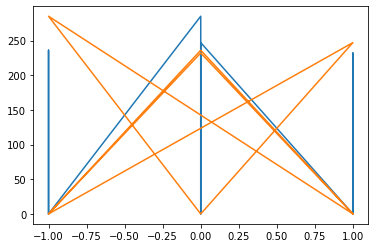

In [352]:
print(pos_x)
print(freq_y)

plt.plot(pos_x, freq_y)

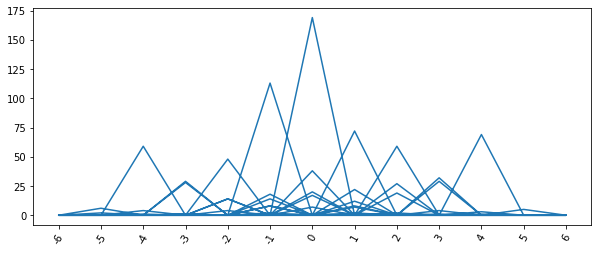

In [361]:
f = plt.figure()
f.set_figwidth(10)
plt_pos_x = [str(i[1]) for i in pos_x]
plt.xticks(rotation=60)
plt.plot(plt_pos_x, freq_y)
# plt.bar(plt_pos_x, freq_y)